Learning starts around episode: 1799 (after approx. 30000 steps)


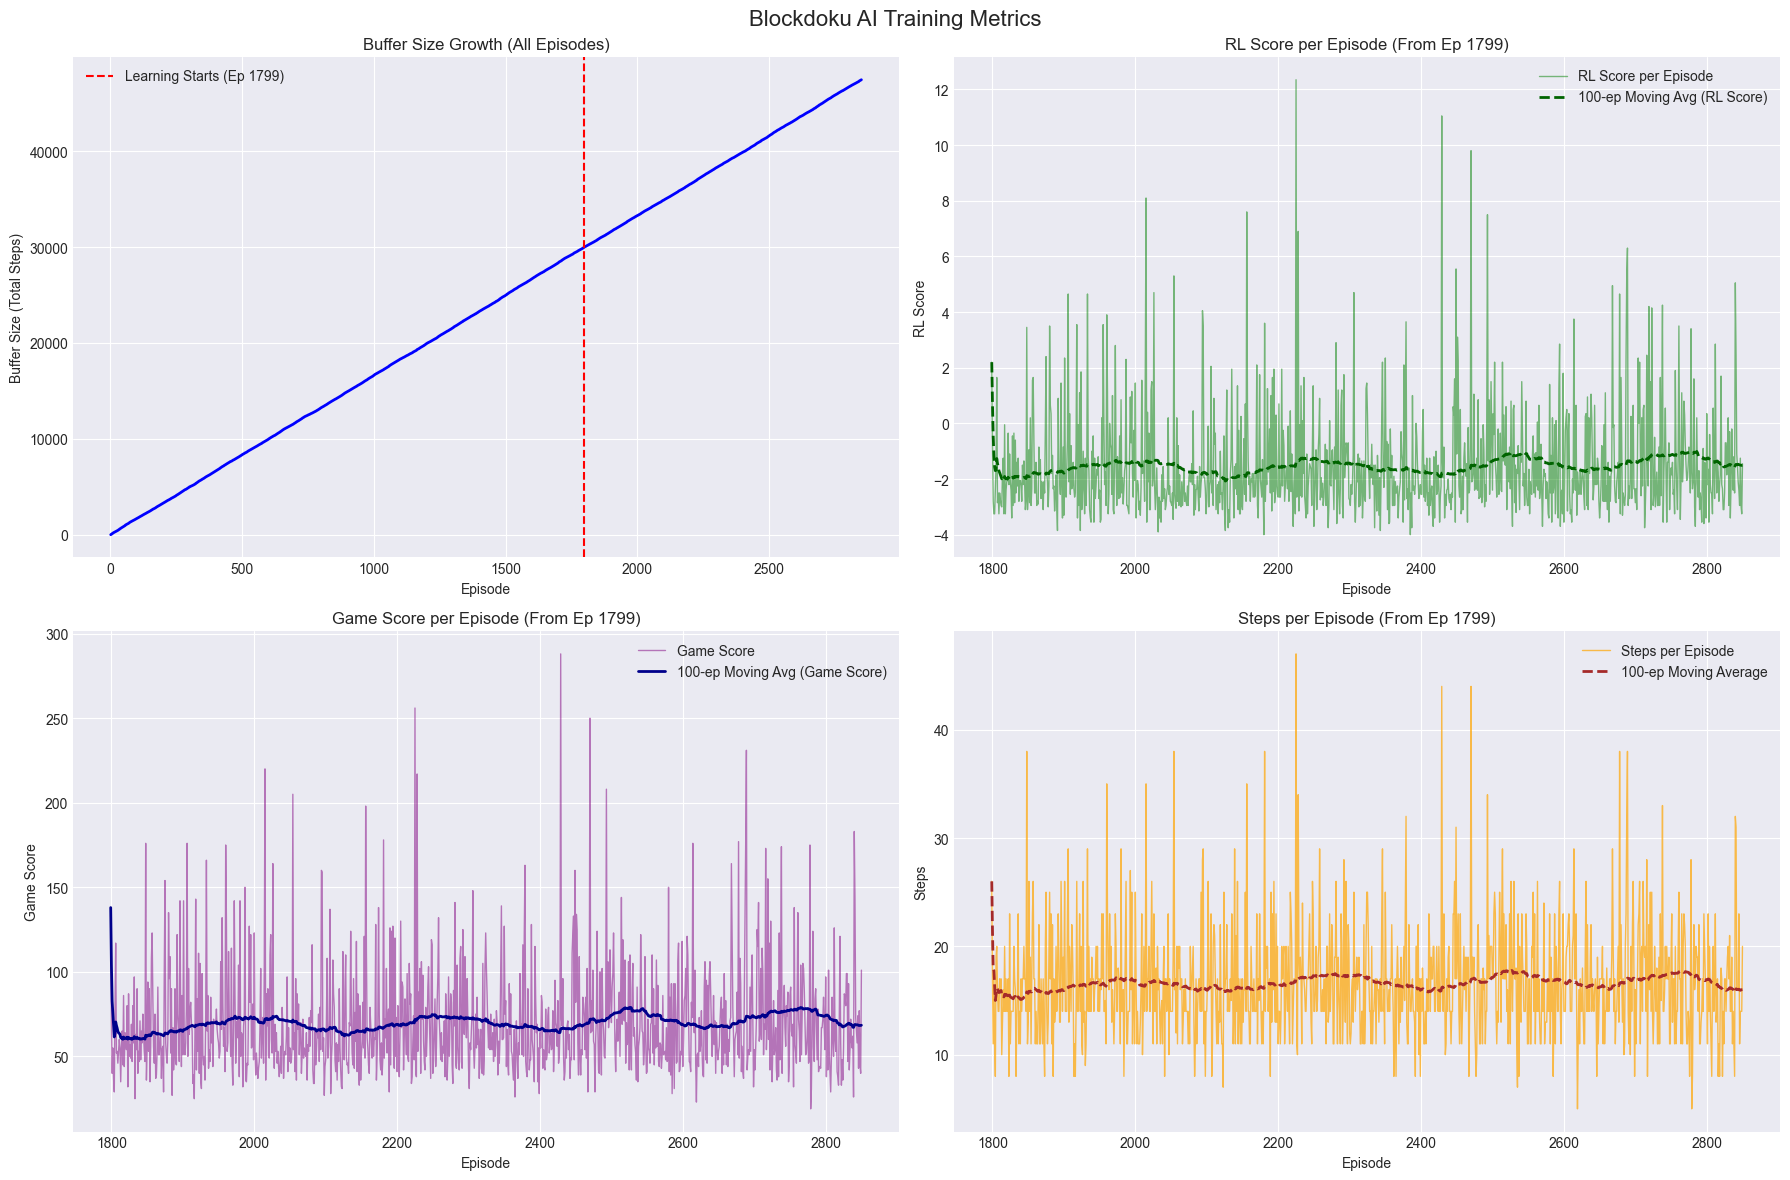

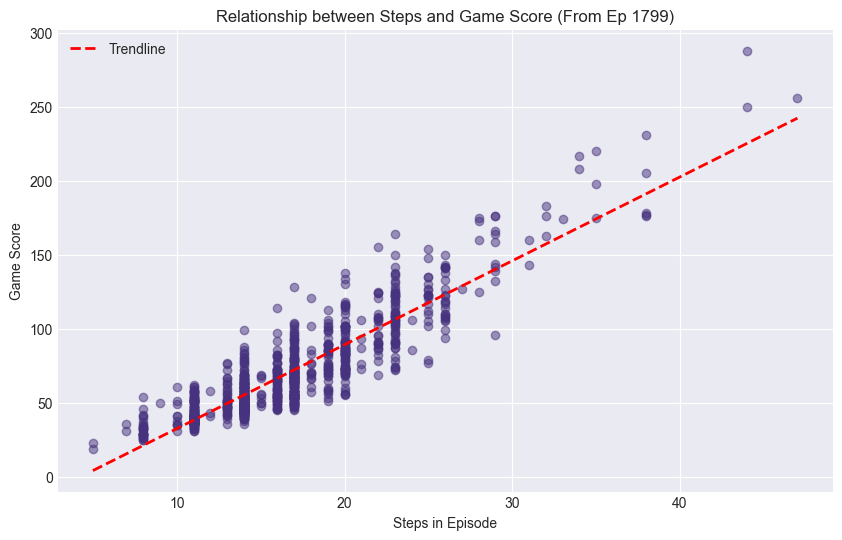

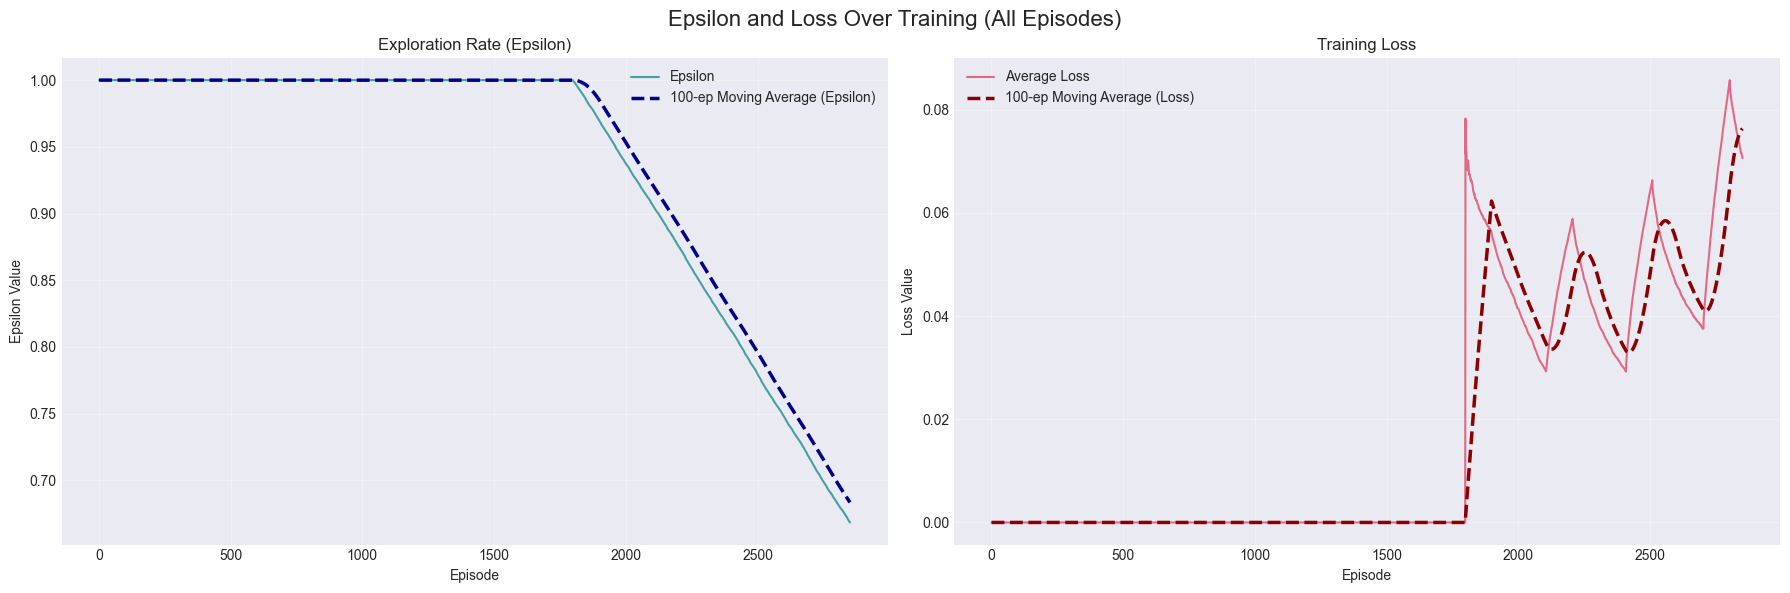

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

# Load the data
log_file_path = "logs/training_log_20250507-125308.json" # Updated log file
try:
    with open(log_file_path, 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: Log file not found at {log_file_path}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {log_file_path}")
    exit()

# Convert episodes list to DataFrame
if 'episodes' not in data or not isinstance(data['episodes'], list) or not data['episodes']:
    print(f"Error: 'episodes' key not found in JSON, is not a list, or is empty.")
    exit()
df = pd.DataFrame(data['episodes'])

if df.empty:
    print("Error: DataFrame is empty after loading episodes. Check log content.")
    exit()

# --- Determine the episode where learning starts ---
# Get LEARNING_STARTS from the settings used for THIS log, if available in JSON,
# otherwise use the value from your settings.py file.
# Assuming LEARNING_STARTS = 10000 steps from your root settings.py
LEARNING_STARTS_STEPS = data.get("settings", {}).get("learning_starts", 10000)


start_learning_episode = 1
learning_starts_df_empty = True # Flag to track if learning_starts_df was populated

if 'buffer_size' in df.columns and 'episode' in df.columns:
    learning_starts_df = df[df['buffer_size'] >= LEARNING_STARTS_STEPS]
    if not learning_starts_df.empty:
        start_learning_episode = learning_starts_df['episode'].iloc[0]
        learning_starts_df_empty = False
        print(f"Learning starts around episode: {start_learning_episode} (after approx. {LEARNING_STARTS_STEPS} steps)")
    else:
        max_buffer_size = df['buffer_size'].max() if not df['buffer_size'].empty else 0
        print(f"Warning: No episode found where buffer_size ({max_buffer_size}) >= LEARNING_STARTS_STEPS ({LEARNING_STARTS_STEPS}). Plotting all data for score/steps.")
elif 'episode' not in df.columns:
    print("Warning: 'episode' column not found in log. Cannot filter by episode. Plotting all data.")
else: # buffer_size column missing
    print("Warning: 'buffer_size' column not found in log. Cannot determine precisely when learning started based on steps. Plotting all data for score/steps.")

# Filter DataFrame for plots that should start from the learning phase
if 'episode' in df.columns:
    df_learning = df[df['episode'] >= start_learning_episode].copy()
else:
    df_learning = df.copy() # Fallback to using all data if 'episode' is missing

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Blockdoku AI Training Metrics', fontsize=16)
window_size = 100 # Moving average window

# 1. Buffer Size plot (shows all data)
if 'episode' in df.columns and 'buffer_size' in df.columns:
    axes[0, 0].plot(df['episode'], df['buffer_size'], color='blue', linewidth=2)
    axes[0, 0].set_title('Buffer Size Growth (All Episodes)')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Buffer Size (Total Steps)')
    if start_learning_episode > 1 and not learning_starts_df_empty:
        axes[0, 0].axvline(x=start_learning_episode, color='r', linestyle='--', label=f'Learning Starts (Ep {start_learning_episode})')
        axes[0, 0].legend()
else:
    axes[0,0].set_title('Buffer Size Data Missing')
axes[0, 0].grid(True)

# 2. RL Score plot (shows data from learning phase)
# The log now contains 'rl_score' and 'avg_rl_score'
rl_score_col = 'rl_score' if 'rl_score' in df.columns else 'score' # Fallback to 'score' if 'rl_score' isn't there

if not df_learning.empty and 'episode' in df_learning.columns and rl_score_col in df_learning.columns:
    axes[0, 1].plot(df_learning['episode'], df_learning[rl_score_col], color='green', linewidth=1, alpha=0.5, label='RL Score per Episode')
    title_suffix_rl = f'(From Ep {start_learning_episode})' if start_learning_episode > 1 and not learning_starts_df_empty else '(All Episodes)'
    axes[0, 1].set_title(f'RL Score per Episode {title_suffix_rl}')
    if len(df_learning[rl_score_col]) >= window_size:
        rl_score_ma_learning = df_learning[rl_score_col].rolling(window=window_size, min_periods=1).mean()
        axes[0, 1].plot(df_learning['episode'], rl_score_ma_learning, 
                        color='darkgreen', linewidth=2, linestyle='--',
                        label=f'{window_size}-ep Moving Avg (RL Score)')
elif 'episode' in df.columns and rl_score_col in df.columns: # Fallback
    axes[0, 1].plot(df['episode'], df[rl_score_col], color='green', linewidth=1, alpha=0.5, label='RL Score (All Ep.)')
    axes[0, 1].set_title('RL Score per Episode (All Episodes)')
    if len(df[rl_score_col]) >= window_size:
        rl_score_ma = df[rl_score_col].rolling(window=window_size, min_periods=1).mean()
        axes[0, 1].plot(df['episode'], rl_score_ma,
                        color='darkgreen', linewidth=2, linestyle='--',
                        label=f'{window_size}-ep Moving Avg (RL Score)')
else:
    axes[0,1].set_title('RL Score Data Missing')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('RL Score')
if 'episode' in df.columns and rl_score_col in df.columns:
    axes[0, 1].legend()
axes[0, 1].grid(True)


# 3. Game Score plot (shows data from learning phase)
game_score_col = 'game_score' if 'game_score' in df.columns else 'game score' # Handle potential space in column name

if not df_learning.empty and 'episode' in df_learning.columns and game_score_col in df_learning.columns:
    axes[1, 0].plot(df_learning['episode'], df_learning[game_score_col], color='purple', linewidth=1, alpha=0.5, label='Game Score')
    title_suffix_game = f'(From Ep {start_learning_episode})' if start_learning_episode > 1 and not learning_starts_df_empty else '(All Episodes)'
    axes[1, 0].set_title(f'Game Score per Episode {title_suffix_game}')
    if len(df_learning[game_score_col]) >= window_size:
        score_ma_learning = df_learning[game_score_col].rolling(window=window_size, min_periods=1).mean()
        axes[1, 0].plot(df_learning['episode'], score_ma_learning, 
                        color='darkblue', linewidth=2,
                        label=f'{window_size}-ep Moving Avg (Game Score)')
elif 'episode' in df.columns and game_score_col in df.columns: # Fallback
    axes[1, 0].plot(df['episode'], df[game_score_col], color='purple', linewidth=1, alpha=0.5, label='Game Score (All Ep.)')
    axes[1, 0].set_title('Game Score per Episode (All Episodes)')
    if len(df[game_score_col]) >= window_size:
        score_ma = df[game_score_col].rolling(window=window_size, min_periods=1).mean()
        axes[1, 0].plot(df['episode'], score_ma,
                        color='darkblue', linewidth=2,
                        label=f'{window_size}-ep Moving Avg (Game Score)')
else:
    axes[1,0].set_title('Game Score Data Missing')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Game Score')
if 'episode' in df.columns and game_score_col in df.columns:
    axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Steps per Episode plot (shows data from learning phase)
if not df_learning.empty and 'episode' in df_learning.columns and 'steps' in df_learning.columns:
    axes[1, 1].plot(df_learning['episode'], df_learning['steps'], color='orange', linewidth=1, alpha=0.7, label='Steps per Episode')
    title_suffix_steps = f'(From Ep {start_learning_episode})' if start_learning_episode > 1 and not learning_starts_df_empty else '(All Episodes)'
    axes[1, 1].set_title(f'Steps per Episode {title_suffix_steps}')
    if len(df_learning['steps']) >= window_size:
        steps_ma_learning = df_learning['steps'].rolling(window=window_size, min_periods=1).mean()
        axes[1, 1].plot(df_learning['episode'], steps_ma_learning, 
                        color='brown', linewidth=2, linestyle='--',
                        label=f'{window_size}-ep Moving Average')
elif 'episode' in df.columns and 'steps' in df.columns: # Fallback
    axes[1, 1].plot(df['episode'], df['steps'], color='orange', linewidth=1, alpha=0.7, label='Steps per Episode (All Ep.)')
    axes[1, 1].set_title('Steps per Episode (All Episodes)')
    if len(df['steps']) >= window_size:
        steps_ma = df['steps'].rolling(window=window_size, min_periods=1).mean()
        axes[1, 1].plot(df['episode'], steps_ma,
                        color='brown', linewidth=2, linestyle='--',
                        label=f'{window_size}-ep Moving Average')
else:
    axes[1,1].set_title('Steps Data Missing')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Steps')
if 'episode' in df.columns and 'steps' in df.columns:
    axes[1, 1].legend()
axes[1, 1].grid(True)


plt.tight_layout()
plt.subplots_adjust(top=0.94) 
plt.show()

# Create another figure to analyze the correlation between game score and steps
# This will also use data from the learning phase onwards
plt.figure(figsize=(10, 6))
plot_data_for_correlation = df_learning if start_learning_episode > 1 and not learning_starts_df_empty and not df_learning.empty else df

if not plot_data_for_correlation.empty and 'steps' in plot_data_for_correlation.columns and game_score_col in plot_data_for_correlation.columns:
    plt.scatter(plot_data_for_correlation['steps'], plot_data_for_correlation[game_score_col], alpha=0.5)
    title_suffix_corr = f'(From Ep {start_learning_episode})' if start_learning_episode > 1 and not learning_starts_df_empty and not df_learning.empty else '(All Episodes)'
    plt.title(f'Relationship between Steps and Game Score {title_suffix_corr}')
    
    valid_corr_data = plot_data_for_correlation[['steps', game_score_col]].dropna()
    if len(valid_corr_data) > 1: 
        z = np.polyfit(valid_corr_data['steps'], valid_corr_data[game_score_col], 1)
        p = np.poly1d(z)
        min_steps = valid_corr_data['steps'].min()
        max_steps = valid_corr_data['steps'].max()
        if min_steps is not np.nan and max_steps is not np.nan and min_steps < max_steps :
             plt.plot(np.arange(min_steps, max_steps + 1), p(np.arange(min_steps, max_steps + 1)), "r--", linewidth=2, label='Trendline')
        plt.legend()
else:
    plt.title('Steps vs Game Score Data Missing or Insufficient')

plt.xlabel('Steps in Episode')
plt.ylabel('Game Score')
plt.grid(True)
plt.show()


# Plot epsilon and loss values over training (all episodes)
fig_el, axes_el = plt.subplots(1, 2, figsize=(18, 6))
fig_el.suptitle('Epsilon and Loss Over Training (All Episodes)', fontsize=16)

# Epsilon plot
if 'episode' in df.columns and 'epsilon' in df.columns:
    axes_el[0].plot(df['episode'], df['epsilon'], color='teal', linewidth=1.5, alpha=0.7, label='Epsilon')
    if len(df['epsilon']) >= window_size:
        epsilon_ma = df['epsilon'].rolling(window=window_size, min_periods=1).mean()
        axes_el[0].plot(df['episode'], epsilon_ma, 
                 color='darkblue', linewidth=2.5, linestyle='--',
                 label=f'{window_size}-ep Moving Average (Epsilon)')
    axes_el[0].set_title('Exploration Rate (Epsilon)')
    axes_el[0].set_xlabel('Episode')
    axes_el[0].set_ylabel('Epsilon Value')
    axes_el[0].grid(True, alpha=0.3)
    axes_el[0].legend()
else:
    axes_el[0].set_title('Epsilon Data Missing')

# Loss plot
if 'episode' in df.columns and 'avg_loss' in df.columns:
    axes_el[1].plot(df['episode'], df['avg_loss'], color='crimson', linewidth=1.5, alpha=0.6, label='Average Loss')
    if len(df['avg_loss']) >= window_size:
        loss_ma = df['avg_loss'].rolling(window=window_size, min_periods=1).mean()
        axes_el[1].plot(df['episode'], loss_ma, 
                 color='darkred', linewidth=2.5, linestyle='--',
                 label=f'{window_size}-ep Moving Average (Loss)')
    axes_el[1].set_title('Training Loss')
    axes_el[1].set_xlabel('Episode')
    axes_el[1].set_ylabel('Loss Value')
    axes_el[1].grid(True, alpha=0.3)
    axes_el[1].legend()
else:
    axes_el[1].set_title('Loss Data Missing')

plt.tight_layout()
plt.subplots_adjust(top=0.90) 
plt.show()

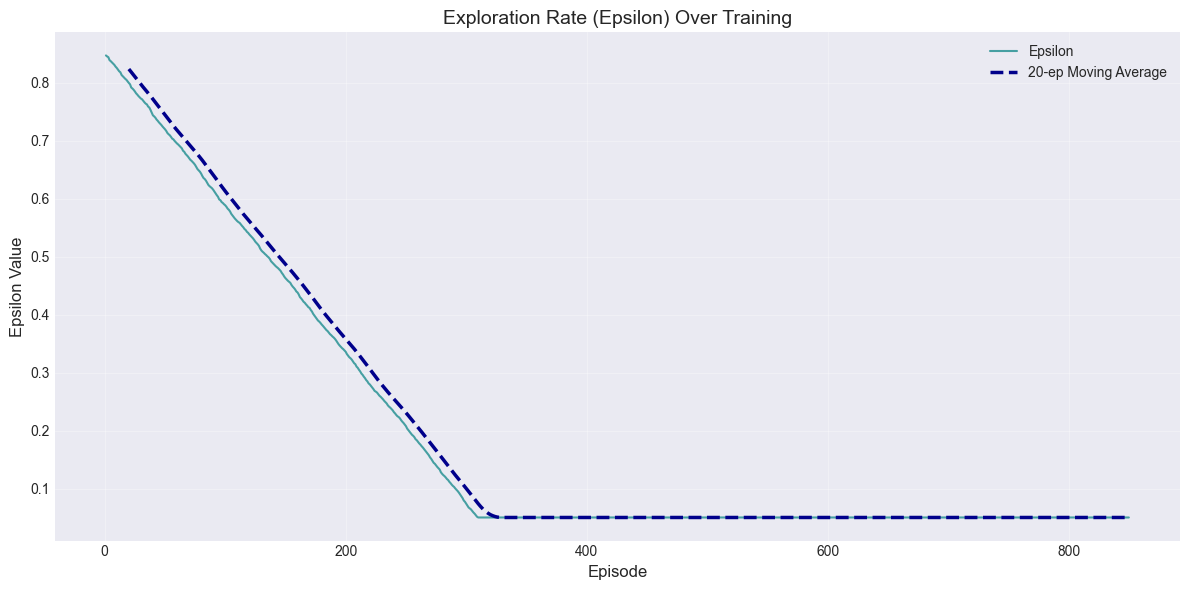

In [5]:
# Plot epsilon values over training
plt.figure(figsize=(12, 6))

# Main epsilon plot
plt.plot(df['episode'], df['epsilon'], color='teal', linewidth=1.5, alpha=0.7, label='Epsilon')

# Add moving average line
window_size = 20
epsilon_ma = df['epsilon'].rolling(window=window_size).mean()
plt.plot(df['episode'][window_size-1:], epsilon_ma[window_size-1:], 
         color='darkblue', linewidth=2.5, linestyle='--',
         label=f'{window_size}-ep Moving Average')

# Add styling and labels
plt.title('Exploration Rate (Epsilon) Over Training', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Epsilon Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

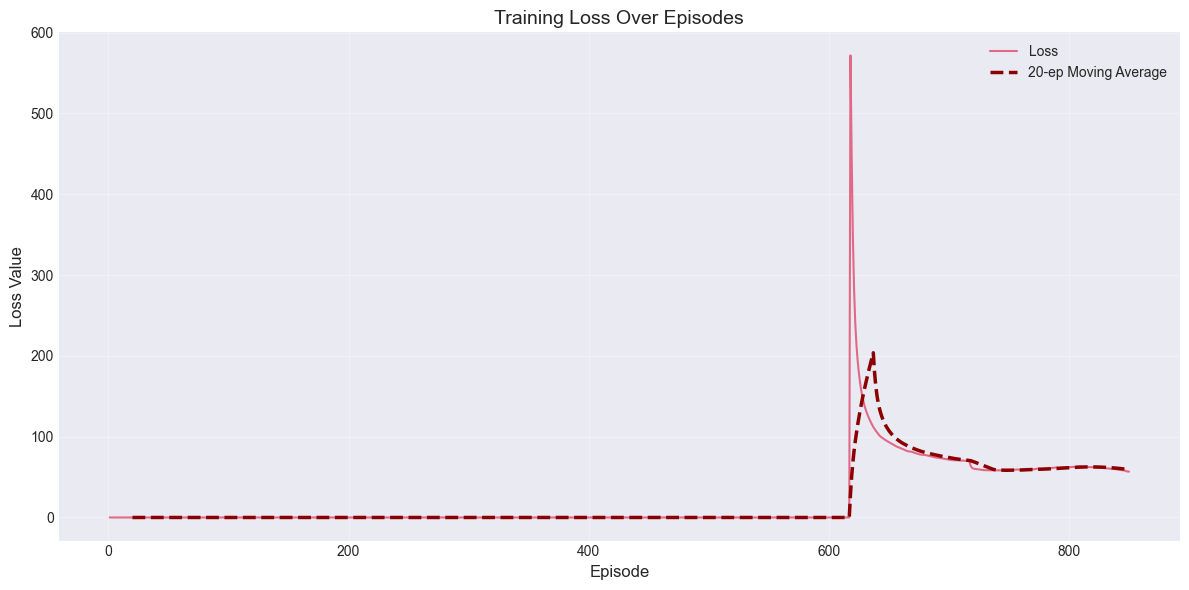

In [6]:
# Plot loss values over training
plt.figure(figsize=(12, 6))

# Check if loss data exists in the DataFrame
if 'avg_loss' in df.columns:
    # Main loss plot
    plt.plot(df['episode'], df['avg_loss'], color='crimson', linewidth=1.5, alpha=0.6, label='Loss')
    
    # Add moving average line
    window_size = 20
    loss_ma = df['avg_loss'].rolling(window=window_size).mean()
    plt.plot(df['episode'][window_size-1:], loss_ma[window_size-1:], 
             color='darkred', linewidth=2.5, linestyle='--',
             label=f'{window_size}-ep Moving Average')
    
    # Add styling and labels
    plt.title('Training Loss Over Episodes', fontsize=14)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("Loss data not found in the training log. Make sure 'avg_loss' is being recorded.")